**Подключение библиотек и скриптов**

In [196]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (roc_auc_score, roc_curve, auc, confusion_matrix, \
                             accuracy_score, classification_report, plot_confusion_matrix, \
                             plot_precision_recall_curve, precision_recall_curve, recall_score,
                             plot_roc_curve)
import catboost as catb
from sklearn.svm import SVC

**Пути к директориям и файлам**

In [197]:
DATASET_PATH = './train.csv'
DATASET_PATH_TEST = './test.csv'

# Постановка задачи

Требуется на основании демографических данных о клиентах банка, истории их платежей и состоянии счета, предсказать невыполнение их обязательств по кредитной карте в следующем месяце.

# Загрузка данных

In [198]:
df = pd.read_csv(DATASET_PATH)
df_test = pd.read_csv(DATASET_PATH_TEST)
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [199]:
df.shape

(7500, 17)

In [200]:
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [201]:
df.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

In [202]:
df.columns

Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Credit Default'],
      dtype='object')

In [203]:
TARGET_NAME = "Credit Default"

In [204]:
BASE_FEATURE_NAMES = ['Home Ownership', 'Annual Income',  'Tax Liens',
                      'Number of Open Accounts', 'Years of Credit History','Maximum Open Credit', 
                      'Number of Credit Problems','Months since last delinquent', 'Bankruptcies', 
                      'Purpose', 'Term','Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
                      'Credit Score', 'Credit Default']

In [205]:
NUM_FEATURE_NAMES = ['Annual Income', 'Years in current job', 'Tax Liens',
                      'Number of Open Accounts', 'Years of Credit History','Maximum Open Credit', 
                      'Number of Credit Problems','Months since last delinquent', 'Bankruptcies', 
                     'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
                      'Credit Score', 'Credit Default']

In [206]:
CAT_FEATURE_NAMES = ['Home Ownership','Years in current job', 'Purpose', 'Term',]

# Функция для обработки пропусков

In [207]:
df = pd.read_csv(DATASET_PATH)
df_test = pd.read_csv(DATASET_PATH_TEST)

In [208]:
df_full = pd.concat([df, df_test])

In [209]:
df_full.isna().sum()

Home Ownership                     0
Annual Income                   2070
Years in current job             457
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    5439
Bankruptcies                      17
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    2070
Credit Default                  2500
dtype: int64

Построю диаграмы для тех признаков, где есть пропуски, чтобы определить, на что их заменять. Строю по общей выборке (включая тест)

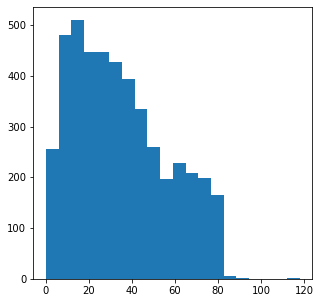

In [210]:
df_full["Months since last delinquent"].hist(figsize=(5,5), bins=20, grid=False);

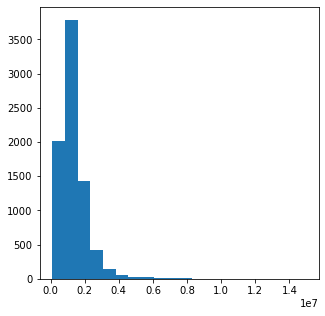

In [211]:
df_full["Annual Income"].hist(figsize=(5,5), bins=20, grid=False);

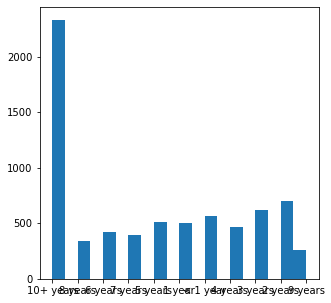

In [212]:
df["Years in current job"].hist(figsize=(5,5), bins=20, grid=False);

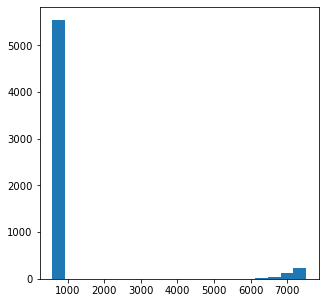

In [213]:
df["Credit Score"].hist(figsize=(5,5), bins=20, grid=False);

Видно, что гистограмма неинформативна из-за наличия выбросов, поэтому построю новую, исключая значения большие 1000. Заменю на медиану пропуски (медиану определяю без учета выбросов)

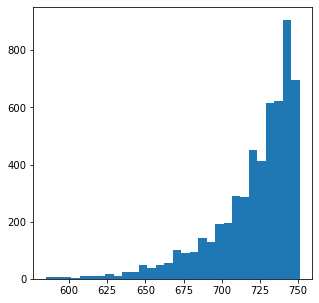

In [214]:
df.loc[df['Credit Score'] < 1000, 'Credit Score'].hist(figsize=(5,5), bins=30, grid=False);

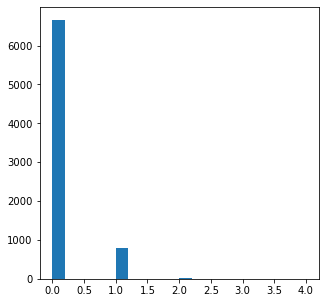

In [215]:
df["Bankruptcies"].hist(figsize=(5,5), bins=20, grid=False);

In [216]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        self.modes =None
        self.means =None
             
        
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        # Расчет мод
        self.modes = X.mode()
         # Расчет средних
        self.means =X.mean()
        self.median_credit = df.loc[df['Credit Score'] < 1000, 'Credit Score'].sort_values().median()
            
    def transform(self, X):
        """Трансформация данных"""

        # Months since last delinquent
         
        X['Months since last delinquent'] = X['Months since last delinquent'].fillna(self.medians['Months since last delinquent'])
        X['Annual Income'] = X['Annual Income'].fillna(self.medians['Annual Income'])      
        X['Years in current job'] = X['Years in current job'].fillna(str(self.modes['Years in current job']))      
        X['Annual Income'] = X['Annual Income'].fillna(self.medians['Annual Income'])      
        X['Credit Score'] = X['Credit Score'].fillna(self.median_credit)      
        X['Bankruptcies'] = X['Bankruptcies'].fillna(self.medians['Bankruptcies']) 
        
        
        return X

In [217]:
preprocessor = DataPreprocessing()
preprocessor.fit(df_full)


In [218]:
df = preprocessor.transform(df)
df_test = preprocessor.transform(df_test)
df.shape, df_test.shape

((7500, 17), (2500, 16))

In [219]:
df_test.isna().sum()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
dtype: int64

In [220]:
df.isna().sum()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
dtype: int64

# Обработка выбросов

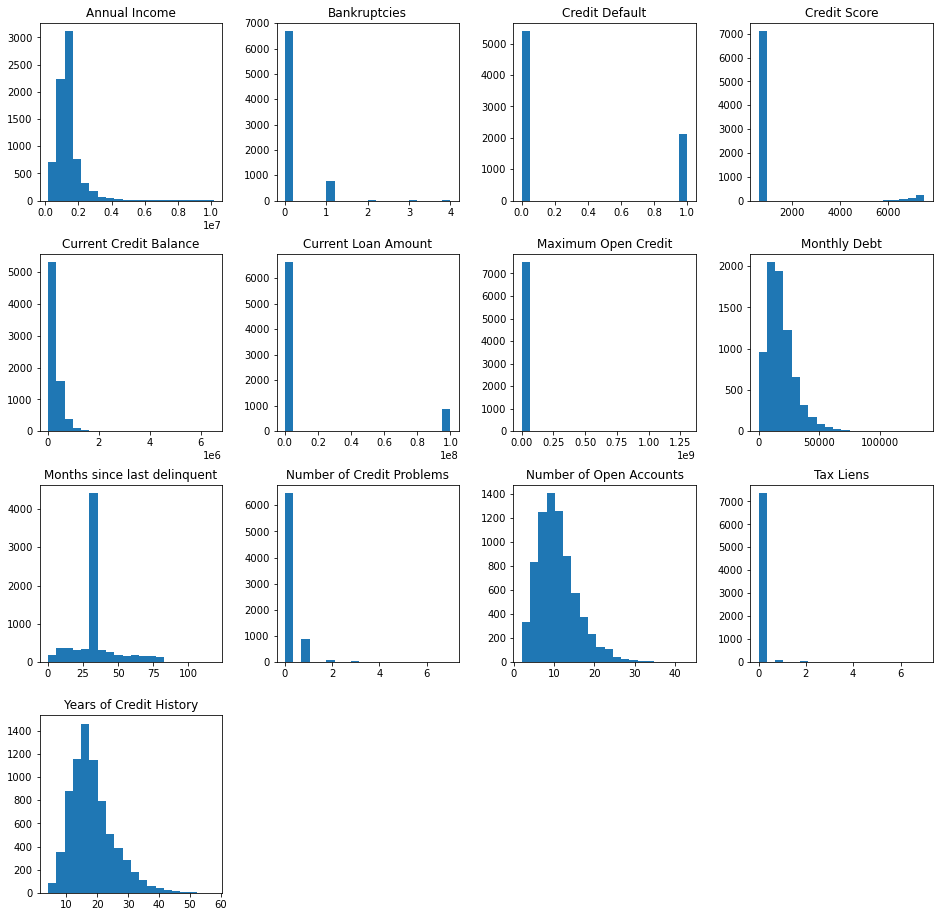

In [221]:
df[NUM_FEATURE_NAMES].hist(figsize=(16,16), bins=20, grid=False);

In [222]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler


def imputer_rfr(data, target_col):
    data = data.copy()
    
    features = data.columns
    
    data = data[features]
    
    train = data[~data[target_col].isna()]
    predict_data = data[data[target_col].isna()]

    X = train.drop(columns=target_col)

    
    #убрала категориальные признаки  

    for cat_colname in df.select_dtypes(include='object').columns:
        X = X.drop(columns=cat_colname) 
        predict_data = predict_data.drop(columns=cat_colname)
      #убрала категориальные признаки  
    
    
    y = train[target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        random_state=32)
    
    model = RandomForestRegressor(n_estimators=100,
                                  max_depth=10,
                                  random_state=42,
                                  verbose=1)
    model.fit(X_train, y_train)
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    print(f"r2 на train: {r2_score(y_train, pred_train)}")
    print(f"r2 на test: {r2_score(y_test, pred_test)}")

    pred = model.predict(predict_data.drop(columns=target_col))

    data.loc[data[target_col].isna(), target_col] = list(pred)
    return model, data

In [223]:
df_copy = df.copy()
df_test_copy = df_test.copy()


# Annual Income

In [224]:
def preprocess_outlier(df, col, threshold):
    
    df.loc[df[col] > threshold, col] = np.nan
    return df


In [225]:
feature_name = 'Annual Income'
df_copy = preprocess_outlier(df_copy, feature_name, threshold=5000000)
df_test_copy = preprocess_outlier(df_test_copy, feature_name, threshold=5000000)

df_copy[feature_name].isna().sum()

44

In [226]:
df_test_copy[feature_name].isna().sum()

14

In [227]:
annual_income_predictor, df_copy = imputer_rfr(df_copy, feature_name)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


r2 на train: 0.7373307450045401
r2 на test: 0.44042406971121284


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [228]:
annual_income_predictor_test, df_test_copy = imputer_rfr(df_test_copy, feature_name)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


r2 на train: 0.8114465734861578
r2 на test: 0.3380567809358135


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


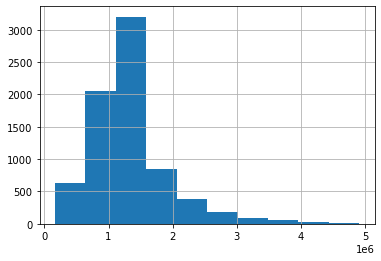

In [229]:
df_copy[feature_name].hist();

# Bankruptcies                    

In [230]:
feature_name = 'Bankruptcies'

In [231]:
def preprocess_outlier(df, col, threshold):
    
    df.loc[df[col] > threshold, col] = np.nan
    return df

In [232]:

df_copy = preprocess_outlier(df_copy, feature_name, threshold=2)
df_test_copy = preprocess_outlier(df_test_copy, feature_name, threshold=2)

df_copy[feature_name].isna().sum()

9

In [233]:
bankruptcies_predictor, df_copy = imputer_rfr(df_copy, feature_name)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


r2 на train: 0.9403933377534613
r2 на test: 0.8342451880895074


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [234]:
bankruptcies_predictor_test, df_test_copy = imputer_rfr(df_test_copy, feature_name)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


r2 на train: 0.9622034505562143
r2 на test: 0.7520829527821344


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


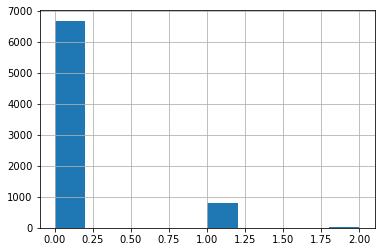

In [235]:
df_copy[feature_name].hist();

# Credit Score

In [236]:
feature_name = 'Credit Score'

In [237]:
def preprocess_outlier(df, col, threshold):
    
    df.loc[df[col] > threshold, col] = np.nan
    return df

In [238]:
df_copy = preprocess_outlier(df_copy, feature_name, threshold=2000)
df_test_copy = preprocess_outlier(df_test_copy, feature_name, threshold=2000)

df_copy[feature_name].isna().sum()

400

In [239]:
credit_score_predictor, df_copy = imputer_rfr(df_copy, feature_name)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


r2 на train: 0.569691059910755
r2 на test: 0.13411190965189868


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [240]:
credit_score_predictor_test, df_test_copy = imputer_rfr(df_test_copy, feature_name)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


r2 на train: 0.6903362857888088
r2 на test: 0.13679738933641017


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


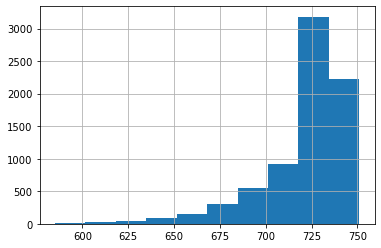

In [241]:
df_copy[feature_name].hist();

# Current Credit Balance  

In [242]:
feature_name = 'Current Credit Balance'

In [243]:
def preprocess_outlier(df, col, threshold):
    
    df.loc[df[col] > threshold, col] = np.nan
    return df

In [244]:
df_copy = preprocess_outlier(df_copy, feature_name, threshold=1600000)
df_test_copy = preprocess_outlier(df_test_copy, feature_name, threshold=1600000)

df_copy[feature_name].isna().sum()

67

In [245]:
credit_bal_predictor, df_copy = imputer_rfr(df_copy, feature_name)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


r2 на train: 0.8827648186816042
r2 на test: 0.674154805433536


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [246]:
credit_bal_predictor_test, df_test_copy = imputer_rfr(df_test_copy, feature_name)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


r2 на train: 0.9047831235492516
r2 на test: 0.6251947815007185


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


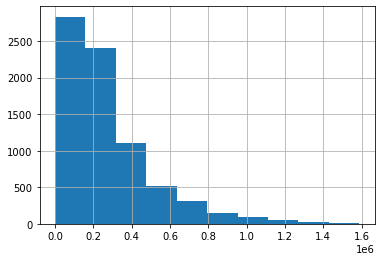

In [247]:
df_copy[feature_name].hist();

# Maximum Open Credit                

In [248]:
feature_name = 'Maximum Open Credit'

In [249]:
    
def preprocess_outlier(df, col, threshold):
    
    df.loc[df[col] > threshold, col] = np.nan
    return df

In [250]:
df_copy = preprocess_outlier(df_copy, feature_name, threshold=3500000)
df_test_copy = preprocess_outlier(df_test_copy, feature_name, threshold=3500000)

df_copy[feature_name].isna().sum()

77

In [251]:
df_test_copy[feature_name].isna().sum()

31

In [252]:
max_credit_predictor, df_copy = imputer_rfr(df_copy, feature_name)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


r2 на train: 0.8571474166973024
r2 на test: 0.6570844147615018


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [253]:
max_credit_predictor_test, df_test_copy = imputer_rfr(df_test_copy, feature_name)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


r2 на train: 0.8847182152017377
r2 на test: 0.6213293371349875


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


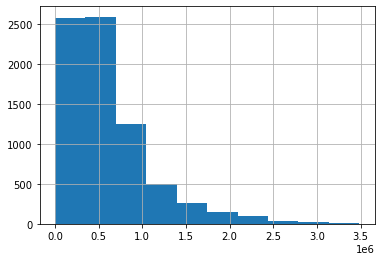

In [254]:
df_copy[feature_name].hist();

# Number of Credit Problems

In [255]:
feature_name = 'Number of Credit Problems'

In [256]:
def preprocess_outlier(df, col, threshold):
    
    df.loc[df[col] > threshold, col] = np.nan
    return df

In [257]:
df_copy = preprocess_outlier(df_copy, feature_name, threshold=2)
df_test_copy = preprocess_outlier(df_test_copy, feature_name, threshold=2)

df_copy[feature_name].isna().sum()

56

In [258]:
num_prob_predictor, df_copy = imputer_rfr(df_copy, feature_name)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


r2 на train: 0.9399870012380661
r2 на test: 0.8772025656353778


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [259]:
num_prob_predictor_test, df_test_copy = imputer_rfr(df_test_copy, feature_name)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


r2 на train: 0.9632982166624455
r2 на test: 0.8527174367345008


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


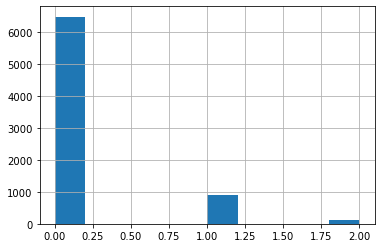

In [260]:
df_copy[feature_name].hist();

# Tax Liens  

In [261]:
feature_name = 'Tax Liens'

In [262]:
def preprocess_outlier(df, col, threshold):
    
    df.loc[df[col] > threshold, col] = np.nan
    return df

In [263]:
df_copy = preprocess_outlier(df_copy, feature_name, threshold=0.5)
df_test_copy = preprocess_outlier(df_test_copy, feature_name, threshold=0.5)

df_copy[feature_name].isna().sum()

134

In [264]:
tax_predictor, df_copy = imputer_rfr(df_copy, feature_name)

r2 на train: 1.0
r2 на test: 1.0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [265]:
tax_predictor_test, df_test_copy = imputer_rfr(df_test_copy, feature_name)

r2 на train: 1.0
r2 на test: 1.0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


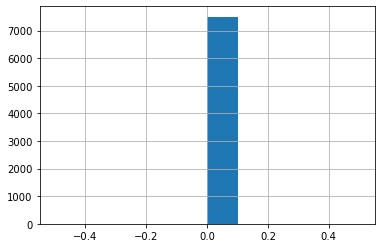

In [266]:
df_copy[feature_name].hist();

In [267]:
df = df_copy

In [268]:
df_test = df_test_copy

## Балансировка классов

In [287]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

2.5294117647058822

In [270]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=2)
#X_train.shape, X_test.shape


In [271]:
#X = df.drop(columns=[TARGET_NAME] + CAT_FEATURE_NAMES)
#y = df[TARGET_NAME]

In [272]:
#df_for_balancing = pd.concat([X, y], axis=1)


In [273]:
#from imblearn.over_sampling import SMOTE
#smote = SMOTE()
#X_smote, y_smote = smote.fit_sample(df_for_balancing.drop(columns=[TARGET_NAME]), df_for_balancing[TARGET_NAME])

In [274]:
#df_balanced = pd.concat([X_smote, y_smote], axis=1)
#df_balanced[TARGET_NAME].value_counts()

In [275]:
#X_balanced = df_balanced.drop(columns=TARGET_NAME)
#y_balanced = df_balanced[TARGET_NAME]

# Сatboost

In [276]:
X = df.drop(columns=[TARGET_NAME])
y = df[TARGET_NAME]

In [277]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=2)
X_train.shape, X_test.shape
#Узнать, как сюда обработно добавить категориальные признаки

((6000, 16), (1500, 16))

In [278]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [279]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [280]:
frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':21,
     'cat_features':CAT_FEATURE_NAMES,
     'eval_metric':'F1',
     'early_stopping_rounds':20
}

In [281]:
model_catb = catb.CatBoostClassifier(**frozen_params, iterations=300, max_depth=3)
model_catb.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.89      0.42      0.57      4300
           1       0.37      0.87      0.52      1700

    accuracy                           0.55      6000
   macro avg       0.63      0.65      0.55      6000
weighted avg       0.75      0.55      0.56      6000

TEST

              precision    recall  f1-score   support

           0       0.88      0.40      0.55      1087
           1       0.35      0.85      0.50       413

    accuracy                           0.53      1500
   macro avg       0.61      0.63      0.52      1500
weighted avg       0.73      0.53      0.54      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               437  650
1                62  351


In [282]:
predictions = model_catb.predict(df_test)


In [283]:
predictions

array([1, 1, 1, ..., 1, 0, 1], dtype=int64)

In [284]:
submit = pd.read_csv('./sample_submission.csv', sep=',')
submit.head()

,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [285]:
submit['Credit Default'] = predictions
submit.head()

,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,0
4,4,1


In [286]:
submit.to_csv('rf_submit.csv', index=False)